# Approximate Bayesian Computation

In [1]:
using Distributions, StatsPlots, Plots, StatsBase, LinearAlgebra,CSV, Random
using LaTeXStrings
using SymPy
using VegaLite
using DataFrames
pyplot()

Plots.PyPlotBackend()

## Discrete Example

In [2]:
n, x = 8, 6
N = 1_000

# Sample θ' from prior π(θ)
# Generate z from p(.|θ')
theta_s = rand(Beta(1,1),N)
z       = rand.(Binomial.(n,theta_s))
theta_a = theta_s[z .== x];
v = collect(range(0, stop=1, length=N));

# aux = sort(DataFrame(x1 = z, x2 = theta_s),:x2)
# z       = aux[!,:x1]
# theta_s = aux[!,:x2];

In [3]:
# k = collect(0:1:n)
# beta_distributions = pdf.(Beta.(x.+k',n .- k' .+1),v);
# plot(v,beta_distributions)

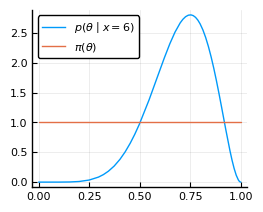

In [4]:
# histogram(theta_a,normalize=true,alpha=0.5)
plot(Beta(x+1,n-x+1),label=L"p(\theta \mid x=6)")
p = plot!(Beta(1,1), label =L"\pi(\theta)",size = (250, 200))
savefig(p,"./vis-project/static/images/distributions.png")

In [5]:
cm = countmap(z)
counter = zeros(length(cm))
hdots = zeros(N)
for (i,v) in enumerate(z)
    counter[v+1]+=1
    hdots[i] = counter[v+1]
end


df = DataFrame([z,hdots,theta_s,collect(1:length(z))]);

In [6]:
CSV.write("./ABC/data/ABC_Beta.csv",df)

"./ABC/data/ABC_Beta.csv"

In [7]:
#         "y": {"field": "x2", "type": "quantitative", "axis": {"grid":false, "title":"Count Samples"}},

WARN Can not resolve event source: window
WARN Can not resolve event source: window
WARN Can not resolve event source: window
WARN Can not resolve event source: window


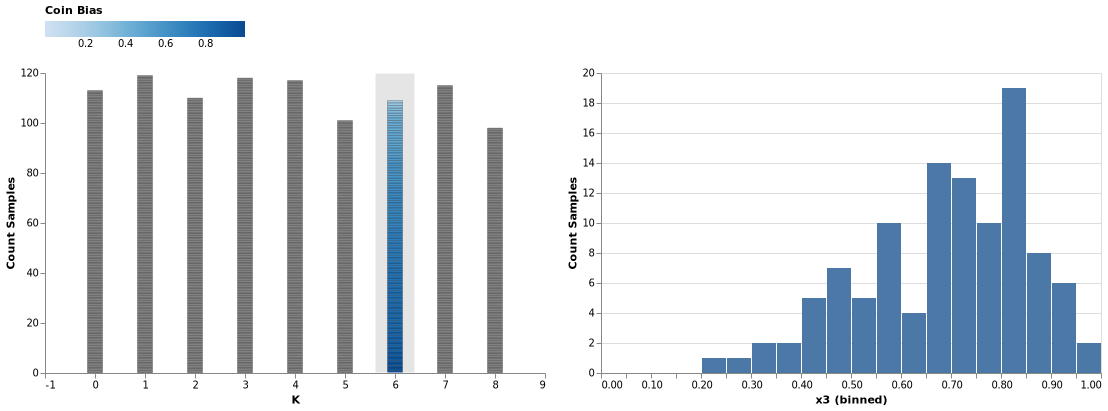

In [8]:
points = df |> vl"""
{
"hconcat" : [
  {

    "view":{"stroke" : null},
    "layer": [{

    
    "selection": {
      "brush": {"type": "interval","encodings": ["x"],"init":{"x": [5.6, 6.4]}}
    },
    "view":{"stroke" : null},
    "width": 500,
    "height": 300,
    "mark": {"type": "bar","stroke": "black",
    "strokeWidth": 0.2},
    "encoding": {
        "x": {"field": "x1", "type": "quantitative","axis": {"grid":false, "title":"K"},"scale":{"domain":[-0.1,8.1]}},
        "y": {"aggregate": "count","type": "quantitative", "axis": {"grid":false, "title":"Count Samples"}},
        "size":{"value":15},
        "color": {
              "condition": {"selection": "brush", "field": "x3", "type": "quantitative","title":"Coin Bias",
              "legend": {"orient": "top", "title": "Coin Bias"}
                            },
              "value": "grey"
            }
        }
}]},
  {
    "layer":[{
    "transform": [
      {"filter": {"selection": "brush"}}
    ],
    "width": 500,
    "height": 300,
    "mark": "bar",
    "encoding": {
    "x": {
        "bin":{"maxbins":20},
        "field": "x3",
        "type": "quantitative"
    },
    "y": {
        "aggregate": "count",
        "type": "quantitative",
        "title": "Count Samples"
      }
    }}
    ]
}]
}
"""

In [9]:
# VegaLite.savespecpec("./ABC/data/ABC_Beta.vegalite", points)

## Continuos Example 

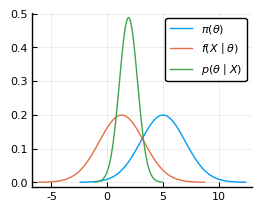

In [14]:
θ = 5.0
σ = 2.0
n = 5
Random.seed!(38);
y = rand(Normal(θ,σ),n) .-3
μ = mean(y)
τ = 2.0
μ1= (μ*n*(1/τ^2) + θ*(1/σ^2))/(n*(1/τ^2)+(1/σ^2))
τ1= sqrt(1/(n*(1/τ^2)+(1/σ^2)))
plot(Normal(θ,σ)   ,label=L"\pi(\theta)")
plot!(Normal(μ,τ)  ,label=L"f(X \mid \theta)")
p = plot!(Normal(μ1,τ1),label=L"p(\theta \mid X)",size=(250,200))
savefig(p,"./vis-project/static/images/normaldistribution.png")

In [29]:
N    = (10^3)
θabc = rand(Normal(θ,σ),N)
z    = rand.(Normal.(θabc,σ),n);
zmean= mean.(z);
rawdistance(z) = sum((z .- y).^2)
ρ_raw   = rawdistance.(z) # Raw Disance
ρ_mean  = (zmean .- mean(y)).^2;
errormean =  zmean .- mean(y);

In [33]:
ϵ_raw  = quantile(ρ_raw,0.05)
ϵ_mean = quantile(ρ_mean,0.05)

0.4256193966984297

In [34]:
θabc_raw  = θabc[ρ_raw .<= ϵ_raw]
θabc_mean = θabc[ρ_mean .<= ϵ_mean];

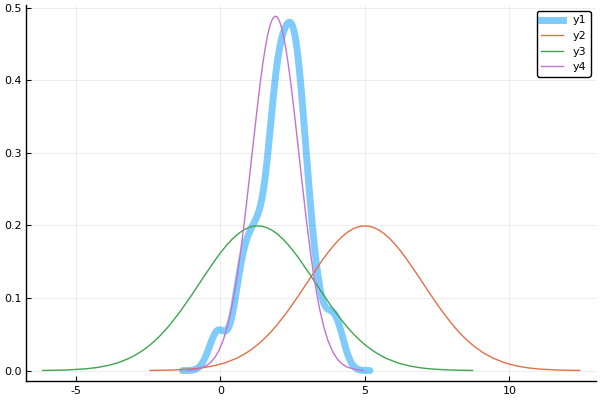

In [35]:
density(θabc_mean,normalize=true,lw=5,alpha=0.5)
# density!(θabc_raw,normalize=true,lw=5,alpha=0.5)
plot!(Normal(θ,σ))
plot!(Normal(μ,τ))
plot!(Normal(μ1,τ1))

In [96]:
grid = collect(range(-5,stop=5, length=N));
analytical = pdf.(Normal(μ1,τ1),grid);

In [97]:
dfn = DataFrame(Zm=zmean,Theta=θabc,Error=ρ_mean,Real=analytical, Grid=grid);

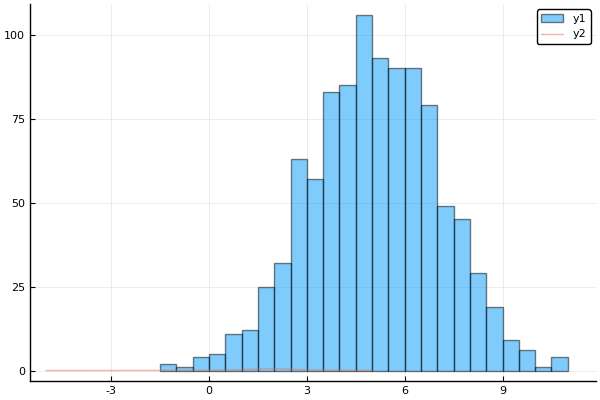

In [98]:
histogram(θabc,normalize=false,alpha=0.5)
plot!(grid,analytical,alpha=0.5)

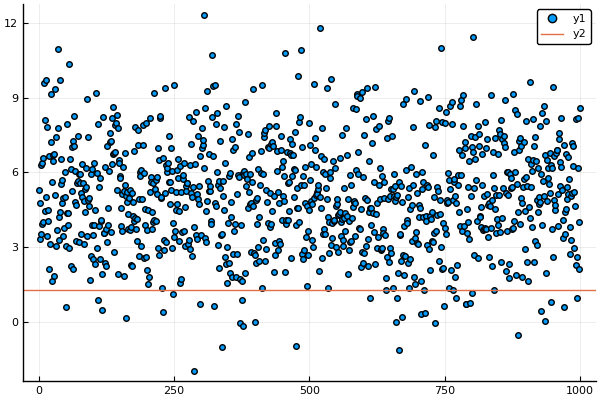

In [99]:
scatter(zmean)
hline!([μ])

WARN Can not resolve event source: window
WARN Can not resolve event source: window
WARN Can not resolve event source: window
WARN Can not resolve event source: window


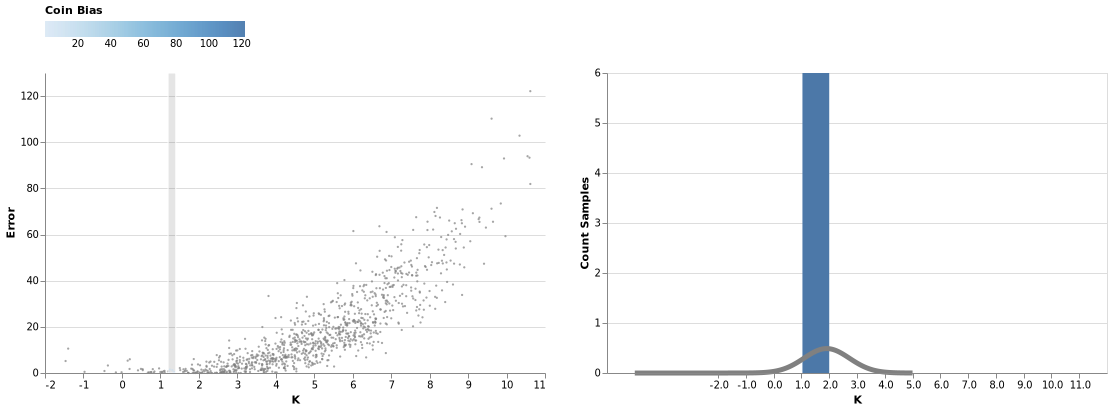

In [114]:
points = dfn |> vl"""
{
"hconcat" : [
  {

    "view":{"stroke" : null},
    "layer": [{

    
    "selection": {
      "brush": {"type": "interval","encodings": ["x"],"init":{"x": [1.2, 1.4]}}
    },
    "view":{"stroke" : null},
    "width": 500,
    "height": 300,
    "mark": {"type": "circle"},
    "encoding": {
        "x": {"field": "Theta", "type": "quantitative","axis": {"grid":false, "title":"K"}},
        "y": {"field": "Error", "type":"quantitative"},
        "size":{"value":5},
        "color": {
              "condition": {"selection": "brush", "field": "Error", "type": "quantitative","title":"Coin Bias",
              "legend": {"orient": "top", "title": "Coin Bias"}
                            },
              "value": "grey"
            }
        }
}]},
  {
    "layer":[{
    "transform": [
      {"filter": {"selection": "brush"}}
    ],
    "width": 500,
    "height": 300,
    "mark": "bar",
    "encoding": {
    "x": {
        "bin":{"maxbins":20},
        "field": "Theta",
        "type": "quantitative"
    },
    "y": {
        "aggregate": "count",
        "type": "quantitative",
        "title": "Count Samples"
      }
    }},
    {
    "mark": {"type": "line"},
    "encoding": {
        "x": {"field": "Grid", "type": "quantitative","axis": {"grid":false, "title":"K"}},
        "y": {"field": "Real", "type":"quantitative"},
        "size":{"value":5},
        "color": {
              "value": "grey"
                }
            }
        }
    ]
}]
}
"""

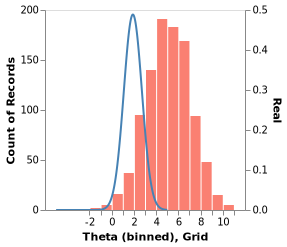

In [138]:
points = dfn |> vl"""
{
      "layer": [
        {
          "mark": {"type": "bar", "color": "salmon"},
          "encoding": {
            "x": {
                "bin":{"maxbins":20},
                "field": "Theta",
                "type": "quantitative"
            },
            "y": {
              "type": "quantitative",
              "aggregate": "count",
              "field": "Theta"
            }
          }
        },
        {
          "mark": {"type": "line", "color": "steelblue"},
          "encoding": {
            "x": {"type": "quantitative", "field": "Grid"},
            "y": {
              "type": "quantitative",
              "field": "Real"
            }
          }
        }
      ],
      "resolve": {"scale": {"y": "independent", "x": "shared"}}
}"""

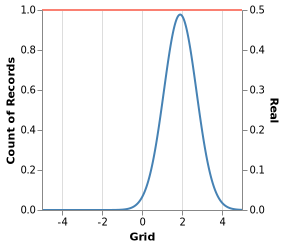

In [134]:
points = dfn |> vl"""
{
      "layer": [
        {
          "mark": {"type": "line", "color": "salmon"},
          "encoding": {
            "x": {"type": "quantitative", "field": "Grid"},
            "y": {
              "type": "quantitative",
              "aggregate": "count",
              "field": "Theta"
            }
          }
        },
        {
          "mark": {"type": "line", "color": "steelblue"},
          "encoding": {
            "x": {"type": "quantitative", "field": "Grid"},
            "y": {
              "type": "quantitative",
              "field": "Real"
            }
          }
        }
      ],
      "resolve": {"scale": {"y": "independent", "x": "shared"}}
}"""

In [125]:
dfn

,Zm,Theta,Error,Real,Grid
,Float64,Float64,Float64,Float64,Float64
1,5.27492,5.90994,15.8761,1.38767e-16,-5.0
2,4.76062,4.76566,12.0422,1.53923e-16,-4.98999
3,3.32428,4.21008,4.13652,1.70709e-16,-4.97998
4,6.27924,4.98179,24.8882,1.89298e-16,-4.96997
5,3.5288,4.27297,5.01028,2.09878e-16,-4.95996
6,3.90872,4.10449,6.85541,2.32662e-16,-4.94995
7,6.35951,5.89271,25.6955,2.5788e-16,-4.93994
8,6.56441,8.14583,27.8148,2.85788e-16,-4.92993
9,3.9983,2.54769,7.33255,3.16669e-16,-4.91992
